In [44]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [35]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k

In [39]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    #snail parameters
    EJ = 30*2*np.pi
    EC = 0.2*2*np.pi
    beta = 0.45
    ng = 0
    ncut = 300
    flux = 0.49
    N = 2
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

    #cavity1 parameters
    omega_c1 = 4.55*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 3
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 4.25*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 3
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    index1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    index2 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    bare_diff = (energy[index1] - energy[index2])/2/np.pi
    
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, index1), basis(total_dim, index2)]
    
    
    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    omegac1p = f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, omegac1p , omega/2/np.pi)
    omegac1p = omegac1p + k *omega/2/np.pi
    omegac2p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, omegac2p, omega/2/np.pi)
    omegac2p = omegac2p + k *omega/2/np.pi
    diff = omegac1p - omegac2p
    return diff

In [45]:
A = 0.5 * 2 * np.pi
omegas = np.linspace(0.25 * 2 * np.pi, 0.35 * 2 * np.pi, 20)

# Parallel computation
results = Parallel(n_jobs=-1)(delayed(energy_diff)(A, omega) for omega in omegas)


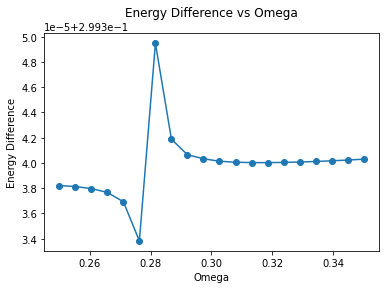

In [47]:
plt.plot(omegas/2/np.pi, results, marker='o')
plt.xlabel('Omega')
plt.ylabel('Energy Difference')
plt.title('Energy Difference vs Omega')
plt.show()